In [8]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, size, when, length
from pyspark.sql import functions as F
import os
os.environ["SPARK_HOME"] = r"C:\Program Files\Spark\spark-3.5.5-bin-hadoop3"

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("ProductRatingAnalysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:3501") \
    .getOrCreate()

# Print PySpark version to verify installation
import pyspark
print(f"PySpark Version: {pyspark.__version__}")
print(f"Hadoop Version: {spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()}")

PySpark Version: 3.5.5
Hadoop Version: 3.3.4


In [9]:
# Load data from HDFS
reviews_path = "hdfs://localhost:3501/datas/appliances/appliances_with_sentiment_score_and_is_spam.parquet"
reviews_df = spark.read.parquet(reviews_path)

meta_path = "hdfs://localhost:3501/datas/appliances/meta_appliances.parquet"
meta_df = spark.read.parquet(meta_path)

reviews_df = reviews_df.withColumn("text_length", length(col("text")))
reviews_df = reviews_df.withColumn("images_length", size(col("images")))
reviews_df = reviews_df.drop("images")
reviews_df = reviews_df.drop("title")
reviews_df = reviews_df.drop("user_id")

meta_df = meta_df.select("parent_asin", "average_rating", "title")

In [10]:
VERIFIED_PURCHASE_MULTIPLIER = 1.5
IMAGES_MULTIPLIER = 2
HAS_TEXT_MULTIPLIER = 2
SPAM_DETECTED_MULTIPLIER = 0.4
SENTIMENT_MISMATCH_PENALTY = 0.5

# Initialize 'rating_weight' as 1
rating_weight = 1

# Multiply by (helpful_vote + 1)
df_with_rating_weight = reviews_df.withColumn("rating_weight", col("helpful_vote") + 1)

# Multiply by 1.5 if verified_purchase is True
df_with_rating_weight = df_with_rating_weight.withColumn(
    "rating_weight",
    when(col("verified_purchase") == True, col("rating_weight") * VERIFIED_PURCHASE_MULTIPLIER).otherwise(col("rating_weight"))
)

# Multiply by 2 if images.length > 0
df_with_rating_weight = df_with_rating_weight.withColumn(
    "rating_weight",
    when(col("images_length") > 0, col("rating_weight") * IMAGES_MULTIPLIER).otherwise(col("rating_weight"))
)

# Multiply by 2 if 'text' is not an empty string
df_with_rating_weight = df_with_rating_weight.withColumn(
    "rating_weight",
    when(col("text_length") > 0, col("rating_weight") * HAS_TEXT_MULTIPLIER).otherwise(col("rating_weight"))
)

# Multiply by 0.2 if 'is_spam' is True
df_with_rating_weight = df_with_rating_weight.withColumn(
    "rating_weight",
    when(col("is_spam") == 1, col("rating_weight") * SPAM_DETECTED_MULTIPLIER).otherwise(col("rating_weight"))
)

# Calculate the difference between 'rating' and 'sentiment_score'
df_with_rating_weight = df_with_rating_weight.withColumn(
    "sentiment_rating_diff", 
    F.abs(col("rating") - col("sentiment_score"))
)

# If the difference is less than or equal to 1, keep the weight as is
# Otherwise, divide the weight by (1 + (difference - 1) * 0.5)
df_with_rating_weight = df_with_rating_weight.withColumn(
    "rating_weight",
    when(col("sentiment_rating_diff") <= 1, col("rating_weight"))
    .otherwise(col("rating_weight") / (1 + (col("sentiment_rating_diff") - 1) * SENTIMENT_MISMATCH_PENALTY))
)

grouped_df = df_with_rating_weight.groupBy("parent_asin").agg(
    F.sum(F.col("rating") * F.col("rating_weight")).alias("weighted_sum_rating"),  # Weighted sum of ratings
    F.sum("rating_weight").alias("total_weight")
)

grouped_df_phase_2 = grouped_df.withColumn(
    "weighted_rating",
    col("weighted_sum_rating") / col("total_weight")
)

In [11]:

# Join the calculated ratings with the metadata ratings using parent_asin = parent_asin
comparison_df = grouped_df_phase_2.join(meta_df, "parent_asin", "left")

# Calculate the difference between our weighted rating and the metadata average rating
comparison_df = comparison_df.withColumn(
    "rating_difference", 
    F.abs(col("weighted_rating") - col("average_rating"))
)

In [12]:
# Sample a small portion of your data
small_comparison_df = comparison_df.limit(100)

# Show results
print("Comparison of calculated weighted ratings with metadata ratings:")
comparison_df.select(
    "parent_asin",
    "title",
    F.round("weighted_rating", 3).alias("our_calculated_rating"),
    F.round("average_rating", 3).alias("amazon_rating"),
    F.round("rating_difference", 3).alias("difference")
).show(20)

# Calculate statistical information about the differences
print("Statistics about rating differences:")
comparison_df.select(
    F.avg("rating_difference").alias("avg_difference"),
    F.stddev("rating_difference").alias("std_dev_difference"),
    F.min("rating_difference").alias("min_difference"),
    F.max("rating_difference").alias("max_difference"),
    F.count("rating_difference").alias("count")
).show()

Comparison of calculated weighted ratings with metadata ratings:
+-----------+--------------------+---------------------+-------------+----------+
|parent_asin|               title|our_calculated_rating|amazon_rating|difference|
+-----------+--------------------+---------------------+-------------+----------+
| B00LGUGJWQ|GE Appliances WD2...|                2.877|          3.9|     1.023|
| B01N9HNALX|Snap to Vent Alum...|                3.646|          4.4|     0.754|
| B0C9TTZW3K|GE Profile Opal 2...|                3.024|          4.3|     1.276|
| B00Y1RZKTY|GE WE4M532 Genuin...|                4.249|          4.5|     0.251|
| B07TH16521|UPGRADED Lifetime...|                4.442|          4.6|     0.158|
| B075M6J6X8|BlueStars Ultra D...|                4.791|          4.7|     0.091|
| B086WMG49L|Panda 2.6 cu.ft C...|                3.473|          4.4|     0.927|
| B07YGMQQGP|Perfect Pod EZ-Cu...|                  4.3|          4.5|       0.2|
| B00UB25GFQ|Edgewater Parts 2...

Created directory: output_graphs


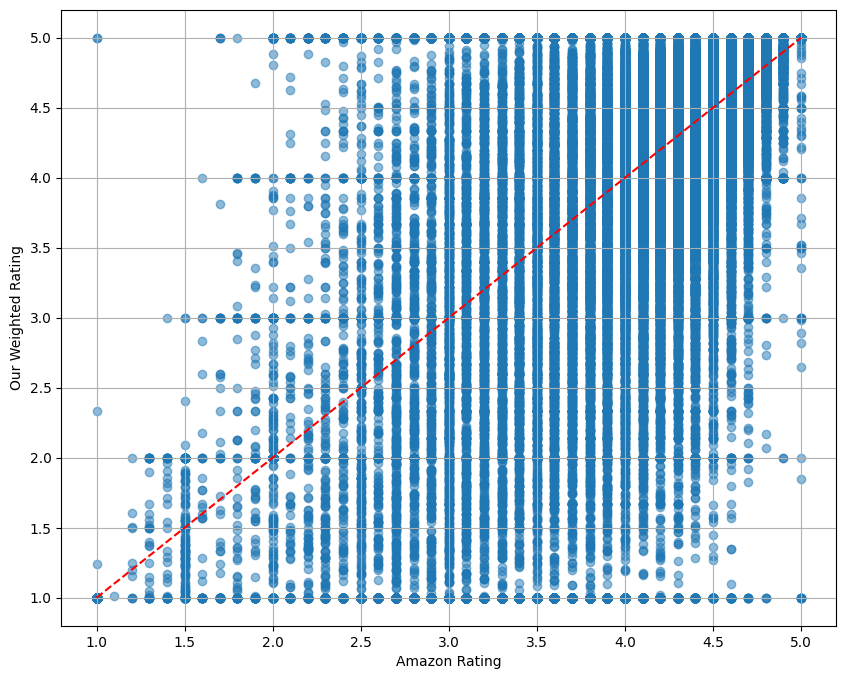

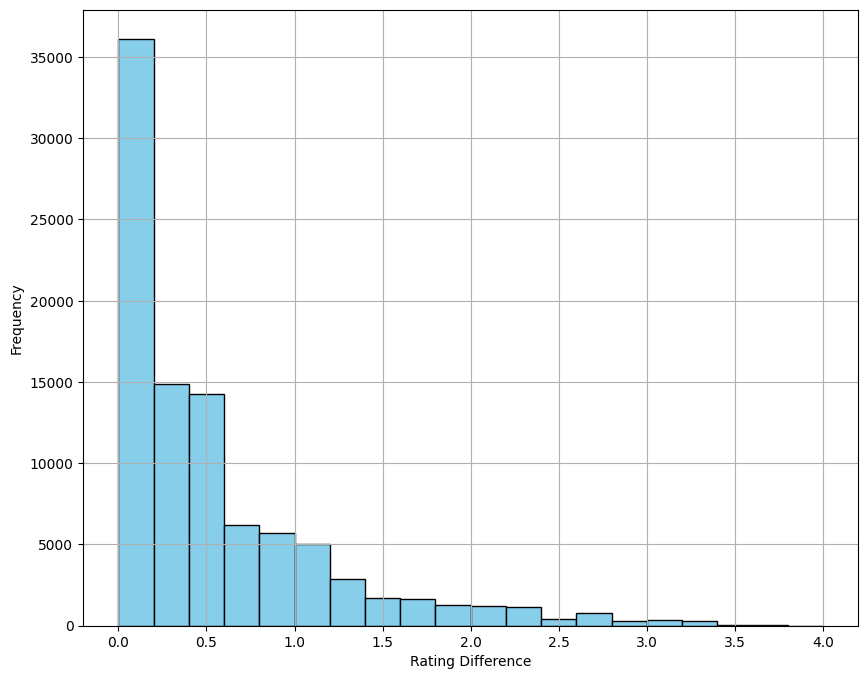

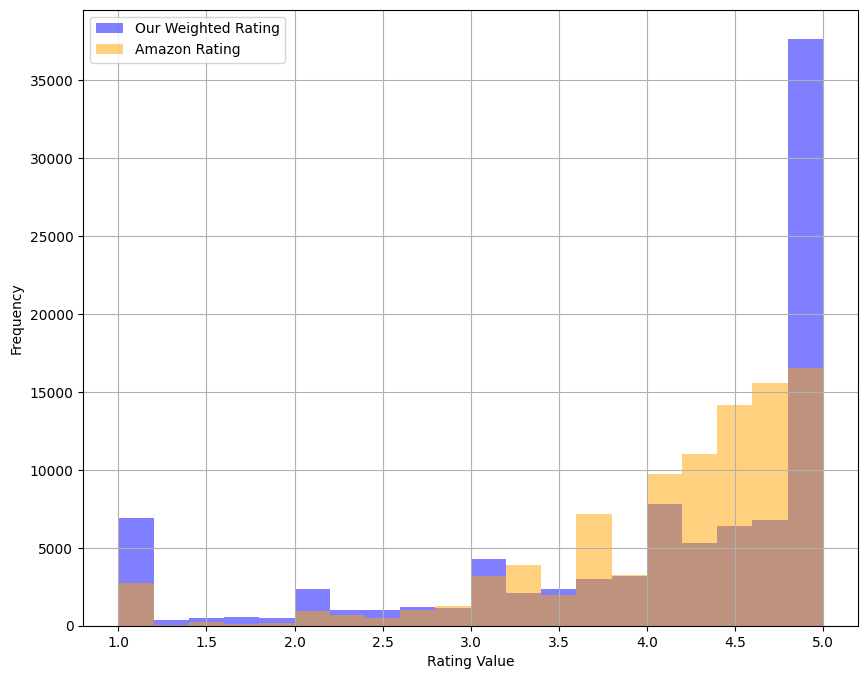

Top 10 Products with Largest Rating Differences:


,parent_asin,title,our_calculated_rating,amazon_rating,difference
62882,B0BL39PZFM,MOCW 5304506660 Lower Spray Wash Arm Compatibl...,5.0,1.0,4.0
42212,B09H2M3CVL,"Egg Holder for Refrigerator, New Drawer Type E...",1.0,5.0,4.0
30744,B0077DCLBE,Whirlpool : GZ9730XSS 30 Under Cabinet Canopy ...,1.0,5.0,4.0
51308,B07HK5NKRT,Yunzee 2PCS/Set Cute Floret Pattern Refrigerat...,1.0,5.0,4.0
74874,B09WYTDJ2W,Coffee Filter Paper Holder Metal Decorative Or...,1.0,5.0,4.0
88093,B0821L3Z4R,ForeverPRO 67005560 Compressor Starting Device...,1.0,5.0,4.0
93714,B0050KK2XU,Whirlpool Part Number 1115244: Thermostat Asse...,1.0,5.0,4.0
90855,B09V2PNLYH,Portable Stainless Steel Coffee Filter Permane...,5.0,1.0,4.0
83570,B004Q3XPN6,Whirlpool W10222037 Dishwasher Spray Arm Genui...,1.0,5.0,4.0
19493,B00CDR00Q2,Samsung DC61-02595A Filter Case,1.0,4.8,3.8


In [ ]:
# Add visualization of the rating comparison
import matplotlib.pyplot as plt
import pandas as pd
import os

# Create output_graphs folder if it doesn't exist
# output_dir = "output_graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     print(f"Created directory: {output_dir}")

# Convert Spark DataFrame to Pandas for easier plotting
pandas_df = comparison_df.select(
    "parent_asin",
    "title",
    F.round("weighted_rating", 3).alias("our_calculated_rating"),
    F.round("average_rating", 3).alias("amazon_rating"),
    F.round("rating_difference", 3).alias("difference")
).toPandas()

# Plot 1: Scatter plot comparing ratings
plt.figure(figsize=(10, 8))
plt.scatter(pandas_df["amazon_rating"], pandas_df["our_calculated_rating"], alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # Diagonal line representing perfect match
plt.xlabel("Amazon Rating")
plt.ylabel("Our Weighted Rating")
plt.grid(True)
# plt.savefig(os.path.join(output_dir, "Comparison of Amazon Ratings vs. Our Weighted Ratings.png"), dpi=300, bbox_inches="tight")
plt.show()

# Plot 2: Histogram of rating differences
plt.figure(figsize=(10, 8))
plt.hist(pandas_df["difference"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Rating Difference")
plt.ylabel("Frequency")
plt.grid(True)
# plt.savefig(os.path.join(output_dir, "Distribution of Rating Differences.png"), dpi=300, bbox_inches="tight")
plt.show()

# Plot 3: Distribution of our ratings vs Amazon ratings
plt.figure(figsize=(10, 8))
plt.hist(pandas_df["our_calculated_rating"], bins=20, alpha=0.5, label="Our Weighted Rating", color='blue')
plt.hist(pandas_df["amazon_rating"], bins=20, alpha=0.5, label="Amazon Rating", color='orange')
plt.xlabel("Rating Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
# plt.savefig(os.path.join(output_dir, "Distribution of Ratings.png"), dpi=300, bbox_inches="tight")
plt.show()

# Additionally, show top 10 products with largest rating differences
print("Top 10 Products with Largest Rating Differences:")
pandas_df.sort_values("difference", ascending=False).head(10)[[
    "parent_asin",
    "title",
    "our_calculated_rating",
    "amazon_rating",
    "difference"
]]

In [14]:
# Stop the Spark session
spark.stop()